# Notebook 07: Proposal Order Amounts

This notebook generates sales orders for the 2022H3 proposal using forecasting and regression predictions generated in [Notebook 4: Forecasting Monthly](04_Forecasting_Monthly.ipynb) and [Notebook 5: Regression Predict Sales](05_Regression_Predict_Sales.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
# Import datasets
proposal = pd.read_csv('../cleaned_datasets/proposal.csv')
proposal_predictions = pd.read_csv('../cleaned_datasets/proposal_forecast.csv')

new_models = pd.read_csv('../cleaned_datasets/proposal_new_models.csv')
new_model_predictions = pd.read_csv('../cleaned_datasets/new_models_predictions.csv')

## Create new dataframe that merges proposal, proposal forecast, new models, and new model predictions to create an overall order.

In [3]:
proposal.head(1)

,style_id,upc_num,priority,case,availability,qty_on_hand,qty_on_order,qty_total,qty_sales_order,qty_sold_last_6m,...,clasp_type,dial_color,movement_type,water_resistant,max_cart_qty,case_size,gender,retail_price,collection,wholesale_price
0,CE1107,796483527706,C,35MM,Available,12.0,0,12.0,10.0,43,...,Fold-over,White,Quartz,100m - 330ft - 10atm,100.0,35.0,Ladies,230.0,Fb - 01,115.0


In [4]:
proposal.columns

Index(['style_id', 'upc_num', 'priority', 'case', 'availability',
       'qty_on_hand', 'qty_on_order', 'qty_total', 'qty_sales_order',
       'qty_sold_last_6m', 'qty_avg/mo', 'months_of_supply', 'cte_cost',
       'qty_cte_cost', 'status', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', '2022-01', '2022-02', '2022-03', '2022-04',
       'total_sales_2022', 'monthly_avg_2022', 'color', 'country_of_origin',
       'warranty', 'band_color', 'band_material', 'case_material',
       'clasp_type', 'dial_color', 'movement_type', 'water_resistant',
       'max_cart_qty', 'case_size', 'gender', 'retail_price', 'collection',
       'wholesale_price'],
      dtype='object')

In [5]:
order_sheet_columns = ['style_id','priority', 'availability', 'qty_total', 'qty_sales_order',
       'cte_cost','max_cart_qty', 'retail_price', 'wholesale_price']

In [6]:
for col in order_sheet_columns:
    if col not in proposal.columns:
        print(f'Proposal missing {col}')
        order_sheet_columns.remove(col)
    if col not in new_models.columns:
        print(f'New models missing {col}')
        order_sheet_columns.remove(col)

New models missing max_cart_qty


In [7]:
order_sheet = proposal[order_sheet_columns]

In [8]:
order_sheet = pd.concat([proposal[order_sheet_columns], new_models[order_sheet_columns]],ignore_index=True)

In [9]:
order_sheet = order_sheet.merge(proposal_predictions, how = 'left', on = 'style_id')
order_sheet = order_sheet.merge(new_model_predictions, how = 'left', on = 'style_id')

In [10]:
order_sheet['quarterly_forecast'] = 0
order_sheet['order'] = 0
for i in order_sheet.index:
    base = 5
    if str(order_sheet.loc[i,'monthly_forecast_Q3']) == "nan":
        quarterly = 3 * order_sheet.loc[i,'monthly_predictions_Q3']
        order = quarterly
    else:
        quarterly = 3 * order_sheet.loc[i,'monthly_forecast_Q3']
        order = quarterly - order_sheet.loc[i,'qty_total']
        if order < 0:
            order = 0
    order_sheet.loc[i,'quarterly_forecast'] = round(quarterly)
    order_sheet.loc[i,'order'] = base * round(order/base)

In [11]:
order_sheet

,style_id,priority,availability,qty_total,qty_sales_order,cte_cost,retail_price,wholesale_price,monthly_forecast_Q3,monthly_predictions_Q3,quarterly_forecast,order
0,CE1107,C,Available,12.0,10.0,80.50,230.0,115.0,5.537037,NaN,17,5
1,CE1108,C,Available,17.0,0.0,80.50,230.0,115.0,2.259259,NaN,7,0
2,CE1111,C,Available,0.0,10.0,80.50,230.0,115.0,0.000000,NaN,0,0
3,CE1112,C,Available,8.0,5.0,80.50,230.0,115.0,3.666667,NaN,11,5
4,CE1113,C,Available,14.0,5.0,80.50,230.0,115.0,4.333333,NaN,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...
295,FS5949,2022h3,Delivery more than 6 weeks,0.0,30.0,54.25,155.0,77.5,NaN,0.770483,2,0
296,FS5950,2022h3,Delivery more than 6 weeks,0.0,30.0,54.25,155.0,77.5,NaN,0.844788,3,5
297,FS5951,2022h3,Delivery more than 6 weeks,0.0,30.0,54.25,155.0,77.5,NaN,0.648255,2,0
298,FS5952,2022h3,Delivery more than 6 weeks,0.0,30.0,54.25,155.0,77.5,NaN,0.770483,2,0


In [12]:
order_sheet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   style_id                300 non-null    object 
 1   priority                300 non-null    object 
 2   availability            300 non-null    object 
 3   qty_total               300 non-null    float64
 4   qty_sales_order         300 non-null    float64
 5   cte_cost                300 non-null    float64
 6   retail_price            300 non-null    float64
 7   wholesale_price         300 non-null    float64
 8   monthly_forecast_Q3     265 non-null    float64
 9   monthly_predictions_Q3  35 non-null     float64
 10  quarterly_forecast      300 non-null    int64  
 11  order                   300 non-null    int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 38.6+ KB


In [13]:
for i in order_sheet.index:
    try:
        order_sheet.loc[i,'qty_sales_order'] - order_sheet.loc[i,'order']
    except:
        print(i)

In [15]:
def plot_preds(y_test, preds, model_name):
    """ This function creates two plots: the predictions against the actual values, and the predictions against the residuals.
    
    Args:
        y_test (Pandas series): actual values
        preds (Pandas series): predictions
    """    
    residuals = y_test - preds
    plt1 = plt.figure()
    plt.scatter(preds,y_test)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.xlabel('Predicted order')
    plt.ylabel('Actual order')
    plt.title(f'Predicted vs Actual Order: {model_name}');

    plt2 = plt.figure()
    plt2.suptitle(f'Residuals vs predicted order: {model_name}')
    sns.residplot(x = y_test,
                  y = residuals,
                  lowess = True,
                  line_kws = {'color':'red'})
    plt.xlabel('Predicted order')
    plt.ylabel('Residuals');
    plt.savefig(f"../images/{model_name.replace(' ','_')}.png")

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


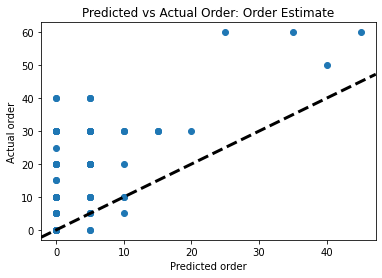

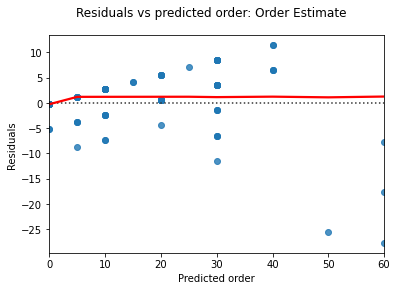

In [16]:
plot_preds(order_sheet['qty_sales_order'], order_sheet['order'], 'Order Estimate')